# Perturb embedding

In [6]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Disable GPU
import numpy as np
import pickle
from tensorflow.keras import models, Model
from tensorflow.keras.layers import Input, LSTM
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs
para_num = 10

lines = []
with open('paper(2 and3)/paper2/vloss.txt', 'r') as file:
    for line in file:
        lines.append(float(line.strip()))
        
# Define the list of target iterations
#target_iterations = [500, 500+4, 500+16, 500+64, 500+256, 500+1024, 500+4096, 500+16384, 500+65536]
target_iterations = [500, 3000]#1600,3000]

# Existing DataSet class (unchanged)
class DataSet():
    def __init__(self, num_words=None, seed=113, maxlen=100, train_portion=0.5, long_first=False):
        from tensorflow.keras.datasets import imdb
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        (self.x_train, self.y_train), (self.x_test, self.y_test) = imdb.load_data(num_words=num_words, seed=seed)
        if long_first:
            self.y_train = [y for _, y in sorted(zip(self.x_train, self.y_train), key=lambda s: len(s[0]), reverse=True)]
            self.x_train = sorted(self.x_train, key=len, reverse=True)
            self.y_test = [y for _, y in sorted(zip(self.x_test, self.y_test), key=lambda s: len(s[0]), reverse=True)]
            self.x_test = sorted(self.x_test, key=len, reverse=True)
        self.total_length = [len(x) for x in self.x_train]
        self.total_length.extend([len(x) for x in self.x_test])
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen, padding='post', truncating='post')
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen, padding='post', truncating='post')
        self.split_data(train_portion)
        self.word_index = imdb.get_word_index()
        self.word_to_index = {word: id + 3 for word, id in self.word_index.items()}
        self.word_to_index["[pad]"] = 0
        self.word_to_index["[start]"] = 1
        self.word_to_index["[unk]"] = 2
        self.word_to_index["[unused]"] = 3
        self.index_to_word = {i: word for (word, i) in self.word_to_index.items()}
        self.form_vocab()

    def form_vocab(self):
        i2w_vocab = {}
        w2i_vocab = {}
        for sentence in self.x_train:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        for sentence in self.x_test:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        self.i2w_vocab = i2w_vocab
        self.w2i_vocab = w2i_vocab

    def get_data(self):
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.train_length, self.test_length)

    def get_vocab_length(self):
        return len(self.i2w_vocab)

    def split_data(self, train_portion):
        x = np.concatenate((self.x_train, self.x_test), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        split_idx = int(train_portion * len(x))
        self.train_length, self.test_length = self.total_length[:split_idx], self.total_length[split_idx:]
        self.x_train, self.x_test = x[:split_idx], x[split_idx:]
        self.y_train, self.y_test = y[:split_idx], y[split_idx:]

# Existing utility functions
def load_lstm_model(n):
    filepath = f'paper(2 and3)/paper2/weights.{"0" + str(n) if n < 10 else str(n)}.hdf5'
    return models.load_model(filepath, compile=False)

def create_new_model(model, current_iterations):
    lstm_layer = model.layers[1]
    lstm_config = lstm_layer.get_config()
    lstm_weights = lstm_layer.get_weights()
    lstm_units = lstm_layer.units
    lstm_config.pop('units', None)
    new_lstm_layer = LSTM(lstm_units, **lstm_config)
    new_input = Input(shape=(current_iterations, 32), dtype=tf.float64)  # Dynamic shape for current iteration
    initial_hidden_state = Input(shape=(lstm_units,))
    initial_cell_state = Input(shape=(lstm_units,))
    output_from_lstm = new_lstm_layer(new_input, initial_state=[initial_hidden_state, initial_cell_state])
    new_lstm_layer.set_weights(lstm_weights)
    return Model(inputs=[new_input, initial_hidden_state, initial_cell_state], outputs=output_from_lstm)

# Revised worker function for parallel processing
def process_model(args):
    """Process a single model and return original results, perturbed results, and distances on hidden states"""
    n, x_in, initial_hidden_state_value, initial_cell_state_value = args
    model = load_lstm_model(n)
    embed_layer = Model(inputs=model.input, outputs=model.layers[0].output)
    
    # Get embedding output once
    embed_output = embed_layer.predict(x_in, verbose=0)  # Shape: (500, 500, 32)
    
    # Add Gaussian noise to embedding output
    noise = np.random.normal(0, 1e-0, size=embed_output.shape)  # Mean=0, std=10^-4
    embed_output_perturbed = embed_output + noise
    
    # Compute results for original and perturbed outputs
    original_results = []
    perturbed_results = []
    distances = []
    for iter_val in target_iterations:
        # Prepare input data for this iteration (original)
        if iter_val <= 500:
            new_data = embed_output[:, :iter_val, :]  # Slice if iteration is less than 500
        else:
            tx = np.zeros((500, iter_val - 500, 32), dtype='float64')  # Pad with zeros if > 500
            new_data = np.concatenate([embed_output, tx], axis=1)
        new_data = np.float64(new_data)  # Shape: (500, iter_val, 32)
        
        # Prepare perturbed input data
        if iter_val <= 500:
            new_data_perturbed = embed_output_perturbed[:, :iter_val, :]
        else:
            tx = np.zeros((500, iter_val - 500, 32), dtype='float64')
            new_data_perturbed = np.concatenate([embed_output_perturbed, tx], axis=1)
        new_data_perturbed = np.float64(new_data_perturbed)
        
        # Create new model for this iteration
        new_model = create_new_model(model, current_iterations=iter_val)
        
        # Predict original hidden states
        hidden_states_original = new_model.predict([new_data, initial_hidden_state_value, initial_cell_state_value], verbose=0)  # Shape: (500, 60)
        original_result = tf.reduce_sum(hidden_states_original * tf.ones(shape=(500, 60)), 1).numpy()  # Reduced sum for consistency
        original_results.append(original_result)
        
        # Predict perturbed hidden states
        hidden_states_perturbed = new_model.predict([new_data_perturbed, initial_hidden_state_value, initial_cell_state_value], verbose=0)  # Shape: (500, 60)
        perturbed_result = tf.reduce_sum(hidden_states_perturbed * tf.ones(shape=(500, 60)), 1).numpy()  # Reduced sum for consistency
        perturbed_results.append(perturbed_result)
        
        # Calculate L2 distance between hidden states for each sample
        sample_distances = np.linalg.norm(hidden_states_original - hidden_states_perturbed, axis=1)  # Shape: (500,)
        distances.append(sample_distances)
    
    return original_results, perturbed_results, distances

# Revised main function
def main(x):
    """Parallelized main function to compute original, perturbed outputs, and distances on hidden states"""
    np.random.seed(42)
    # Initialize states for 500 samples
    initial_hidden_state_value = np.array(np.random.normal(0, 1, size=60).reshape((1, 60)).tolist() * 500)
    initial_cell_state_value = np.zeros((500, 60))
    
    x_in = x.reshape((500, 500))
    num_models = 1000
    num_iterations = len(target_iterations)
    # Result matrices: (num_models, num_iterations, 500)
    original_nums = np.zeros((num_models, num_iterations, 500))  # Reduced sums
    perturbed_nums = np.zeros((num_models, num_iterations, 500))  # Reduced sums
    distances = np.zeros((num_models, num_iterations, 500))  # Distances for each sample
    
    # Prepare arguments for each model
    tasks = [(n + 1, x_in, initial_hidden_state_value, initial_cell_state_value) for n in range(num_models)]
    
    # Use multiprocessing Pool with multiple workers
    with multiprocessing.Pool(processes=para_num) as pool:
        results = pool.map(process_model, tasks)
    
    # Collect results into matrices
    for i, (original_result_list, perturbed_result_list, distance_list) in enumerate(results):
        for j, (original_result, perturbed_result, sample_distances) in enumerate(zip(original_result_list, perturbed_result_list, distance_list)):
            original_nums[i, j] = original_result
            perturbed_nums[i, j] = perturbed_result
            distances[i, j] = sample_distances
    
    return original_nums, perturbed_nums, distances

if __name__ == "__main__":
    # Load dataset
    with open('paper(2 and3)/paper2/dataset_4000_70.pkl', 'rb') as f:
        dataset = pickle.load(f)
    
    _, x, length = dataset.get_data()
    _, length = length
    x, y = x
    original_matrix, perturbed_matrix, distances = main(x[:500])  # Run on first 500 samples
    
    # Print results
    print("Shape of original matrix:", original_matrix.shape)
    print("Shape of perturbed matrix:", perturbed_matrix.shape)
    print("Shape of distances matrix:", distances.shape)
    for idx, iter_val in enumerate(target_iterations):
        print(f"\nIteration {iter_val}:")
        print(f"  Original output shape: {original_matrix[:, idx, :].shape}")
        print(f"  Perturbed output shape: {perturbed_matrix[:, idx, :].shape}")
        print(f"  Mean L2 distance across models and samples: {np.mean(distances[:, idx, :]):.6f}")
        print(f"  Std L2 distance across models and samples: {np.std(distances[:, idx, :]):.6f}")

Shape of original matrix: (1000, 2, 500)
Shape of perturbed matrix: (1000, 2, 500)
Shape of distances matrix: (1000, 2, 500)

Iteration 500:
  Original output shape: (1000, 500)
  Perturbed output shape: (1000, 500)
  Mean L2 distance across models and samples: 3.468274
  Std L2 distance across models and samples: 0.862693

Iteration 3000:
  Original output shape: (1000, 500)
  Perturbed output shape: (1000, 500)
  Mean L2 distance across models and samples: 0.626155
  Std L2 distance across models and samples: 1.113309


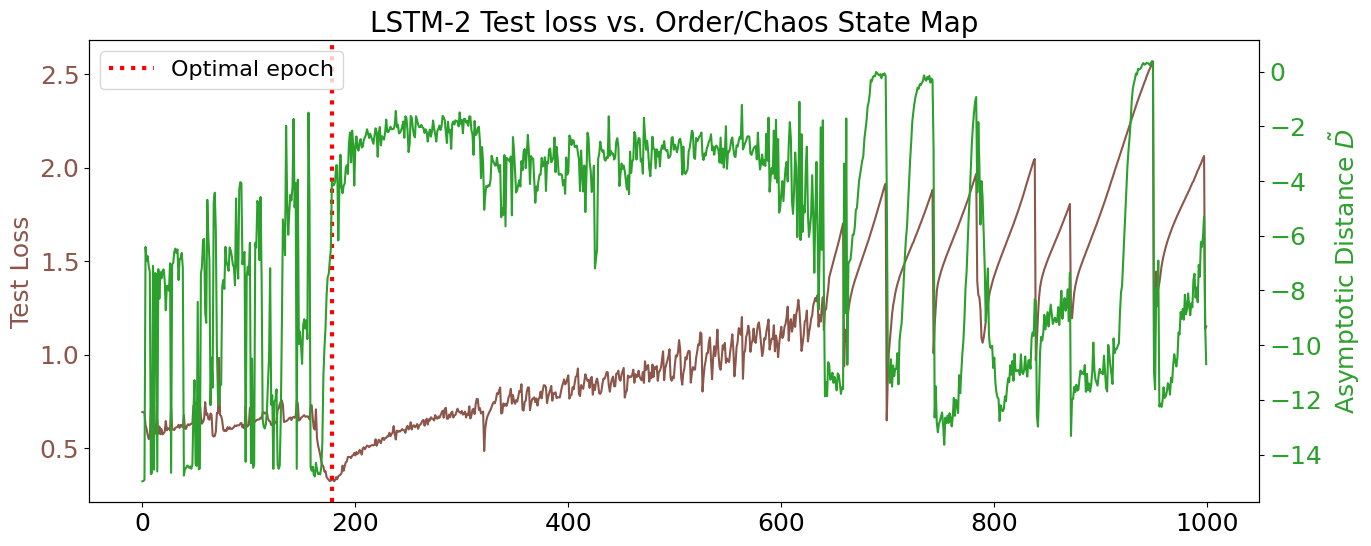

In [7]:
from scipy.stats import gmean
import matplotlib.pyplot as plt

xl=[]
with open('paper(2 and3)/paper2/vloss.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        xl.append(float(line))
len(xl)

xx = gmean(distances[:,-1,:]+np.exp(-14.5-0.5),axis=1)

fig, ax1 = plt.subplots(figsize=(15.1,6))

color = 'tab:brown'
#ax1.set_xlabel('Epoch',fontsize = 16)
ax1.set_ylabel('Test Loss', color=color,fontsize = 18)
ax1.plot(np.arange(1000), xl[:1000], color=color)
# ax1.plot([182-2], xl[179], marker = 'o',label='optimal epoch',color='pink')
ax1.axvline(x = [178],ls=':', color = 'red',label = 'Optimal epoch',lw=3)
ax1.legend(loc='upper left',fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('LSTM-2 Test loss vs. Order/Chaos State Map')
ax1.title.set_size(20)

ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

color = 'tab:green'
title='Asymptotic Distance '+r'$\tilde{D}$'
ax2.set_ylabel(title, color=color,fontsize = 18)
ax2.plot(np.arange(len(xx)),np.log(xx[:len(xx)]),color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
#plt.savefig('TUPIAN/loss-epoch state change map_1.png',transparent=True)
plt.show()


# Perturb h_t

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Disable GPU
import numpy as np
import pickle
from tensorflow.keras import models, Model
from tensorflow.keras.layers import Input, LSTM
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs
para_num = 10

lines = []
with open('paper(2 and3)/paper2/vloss.txt', 'r') as file:
    for line in file:
        lines.append(float(line.strip()))
        
# Define the list of target iterations
target_iterations = [500,1600,3000]

# Existing DataSet class (unchanged)
class DataSet():
    def __init__(self, num_words=None, seed=113, maxlen=100, train_portion=0.5, long_first=False):
        from tensorflow.keras.datasets import imdb
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        (self.x_train, self.y_train), (self.x_test, self.y_test) = imdb.load_data(num_words=num_words, seed=seed)
        if long_first:
            self.y_train = [y for _, y in sorted(zip(self.x_train, self.y_train), key=lambda s: len(s[0]), reverse=True)]
            self.x_train = sorted(self.x_train, key=len, reverse=True)
            self.y_test = [y for _, y in sorted(zip(self.x_test, self.y_test), key=lambda s: len(s[0]), reverse=True)]
            self.x_test = sorted(self.x_test, key=len, reverse=True)
        self.total_length = [len(x) for x in self.x_train]
        self.total_length.extend([len(x) for x in self.x_test])
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen, padding='post', truncating='post')
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen, padding='post', truncating='post')
        self.split_data(train_portion)
        self.word_index = imdb.get_word_index()
        self.word_to_index = {word: id + 3 for word, id in self.word_index.items()}
        self.word_to_index["[pad]"] = 0
        self.word_to_index["[start]"] = 1
        self.word_to_index["[unk]"] = 2
        self.word_to_index["[unused]"] = 3
        self.index_to_word = {i: word for (word, i) in self.word_to_index.items()}
        self.form_vocab()

    def form_vocab(self):
        i2w_vocab = {}
        w2i_vocab = {}
        for sentence in self.x_train:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        for sentence in self.x_test:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        self.i2w_vocab = i2w_vocab
        self.w2i_vocab = w2i_vocab

    def get_data(self):
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.train_length, self.test_length)

    def get_vocab_length(self):
        return len(self.i2w_vocab)

    def split_data(self, train_portion):
        x = np.concatenate((self.x_train, self.x_test), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        split_idx = int(train_portion * len(x))
        self.train_length, self.test_length = self.total_length[:split_idx], self.total_length[split_idx:]
        self.x_train, self.x_test = x[:split_idx], x[split_idx:]
        self.y_train, self.y_test = y[:split_idx], y[split_idx:]

# Existing utility functions
def load_lstm_model(n):
    filepath = f'paper(2 and3)/paper2/weights.{"0" + str(n) if n < 10 else str(n)}.hdf5'
    return models.load_model(filepath, compile=False)

def create_new_model(model, current_iterations):
    lstm_layer = model.layers[1]
    lstm_config = lstm_layer.get_config()
    lstm_weights = lstm_layer.get_weights()
    lstm_units = lstm_layer.units
    lstm_config.pop('units', None)
    new_lstm_layer = LSTM(lstm_units, **lstm_config)
    new_input = Input(shape=(current_iterations, 32), dtype=tf.float64)  # Dynamic shape for current iteration
    initial_hidden_state = Input(shape=(lstm_units,))
    initial_cell_state = Input(shape=(lstm_units,))
    output_from_lstm = new_lstm_layer(new_input, initial_state=[initial_hidden_state, initial_cell_state])
    new_lstm_layer.set_weights(lstm_weights)
    return Model(inputs=[new_input, initial_hidden_state, initial_cell_state], outputs=output_from_lstm)

# Revised worker function for parallel processing
def process_model(args):
    """Process a single model and return original results, perturbed results, and distances on hidden states"""
    n, x_in, initial_hidden_state_value, initial_cell_state_value = args
    model = load_lstm_model(n)
    embed_layer = Model(inputs=model.input, outputs=model.layers[0].output)
    
    # Get embedding output (unperturbed)
    embed_output = embed_layer.predict(x_in, verbose=0)  # Shape: (500, 500, 32)
    
    # Add Gaussian noise to initial hidden state
    noise = np.random.normal(0, 1e-1, size=initial_hidden_state_value.shape)  # Mean=0, std=10^-4, Shape: (500, 60)
    initial_hidden_state_perturbed = initial_hidden_state_value + noise
    
    # Compute results for original and perturbed initial hidden states
    original_results = []
    perturbed_results = []
    distances = []
    for iter_val in target_iterations:
        # Prepare input data for this iteration
        if iter_val <= 500:
            new_data = embed_output[:, :iter_val, :]  # Slice if iteration is less than 500
        else:
            tx = np.zeros((500, iter_val - 500, 32), dtype='float64')  # Pad with zeros if > 500
            new_data = np.concatenate([embed_output, tx], axis=1)
        new_data = np.float64(new_data)  # Shape: (500, iter_val, 32)
        
        # Create new model for this iteration
        new_model = create_new_model(model, current_iterations=iter_val)
        
        # Predict original hidden states
        hidden_states_original = new_model.predict(
            [new_data, initial_hidden_state_value, initial_cell_state_value], verbose=0
        )  # Shape: (500, 60)
        original_result = tf.reduce_sum(hidden_states_original * tf.ones(shape=(500, 60)), 1).numpy()
        original_results.append(original_result)
        
        # Predict perturbed hidden states
        hidden_states_perturbed = new_model.predict(
            [new_data, initial_hidden_state_perturbed, initial_cell_state_value], verbose=0
        )  # Shape: (500, 60)
        perturbed_result = tf.reduce_sum(hidden_states_perturbed * tf.ones(shape=(500, 60)), 1).numpy()
        perturbed_results.append(perturbed_result)
        
        # Calculate L2 distance between hidden states for each sample
        sample_distances = np.linalg.norm(hidden_states_original - hidden_states_perturbed, axis=1)  # Shape: (500,)
        distances.append(sample_distances)
    
    return original_results, perturbed_results, distances

# Main function (unchanged)
def main(x):
    """Parallelized main function to compute original, perturbed outputs, and distances on hidden states"""
    np.random.seed(42)
    # Initialize states for 500 samples
    initial_hidden_state_value = np.array(np.random.normal(0, 1, size=60).reshape((1, 60)).tolist() * 500)
    initial_cell_state_value = np.zeros((500, 60))
    
    x_in = x.reshape((500, 500))
    num_models = 1000
    num_iterations = len(target_iterations)
    original_nums = np.zeros((num_models, num_iterations, 500))  # Reduced sums
    perturbed_nums = np.zeros((num_models, num_iterations, 500))  # Reduced sums
    distances = np.zeros((num_models, num_iterations, 500))  # Distances for each sample
    
    # Prepare arguments for each model
    tasks = [(n + 1, x_in, initial_hidden_state_value, initial_cell_state_value) for n in range(num_models)]
    
    # Use multiprocessing Pool with multiple workers
    with multiprocessing.Pool(processes=para_num) as pool:
        results = pool.map(process_model, tasks)
    
    # Collect results into matrices
    for i, (original_result_list, perturbed_result_list, distance_list) in enumerate(results):
        for j, (original_result, perturbed_result, sample_distances) in enumerate(zip(original_result_list, perturbed_result_list, distance_list)):
            original_nums[i, j] = original_result
            perturbed_nums[i, j] = perturbed_result
            distances[i, j] = sample_distances
    
    return original_nums, perturbed_nums, distances

if __name__ == "__main__":
    # Load dataset
    with open('paper(2 and3)/paper2/dataset_4000_70.pkl', 'rb') as f:
        dataset = pickle.load(f)
    
    _, x, length = dataset.get_data()
    _, length = length
    x, y = x
    original_matrix, perturbed_matrix, distances = main(x[:500])  # Run on first 500 samples
    
    # Print results
    print("Shape of original matrix:", original_matrix.shape)
    print("Shape of perturbed matrix:", perturbed_matrix.shape)
    print("Shape of distances matrix:", distances.shape)
    for idx, iter_val in enumerate(target_iterations):
        print(f"\nIteration {iter_val}:")
        print(f"  Original output shape: {original_matrix[:, idx, :].shape}")
        print(f"  Perturbed output shape: {perturbed_matrix[:, idx, :].shape}")
        print(f"  Mean L2 distance across models and samples: {np.mean(distances[:, idx, :]):.6f}")
        print(f"  Std L2 distance across models and samples: {np.std(distances[:, idx, :]):.6f}")

2025-03-26 03:37:32.258487: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 03:37:34.261610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-26 03:37:34.469949: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025

Shape of original matrix: (1000, 3, 500)
Shape of perturbed matrix: (1000, 3, 500)
Shape of distances matrix: (1000, 3, 500)

Iteration 500:
  Original output shape: (1000, 500)
  Perturbed output shape: (1000, 500)
  Mean L2 distance across models and samples: 0.010801
  Std L2 distance across models and samples: 0.057288

Iteration 1600:
  Original output shape: (1000, 500)
  Perturbed output shape: (1000, 500)
  Mean L2 distance across models and samples: 0.004347
  Std L2 distance across models and samples: 0.061404

Iteration 3000:
  Original output shape: (1000, 500)
  Perturbed output shape: (1000, 500)
  Mean L2 distance across models and samples: 0.003268
  Std L2 distance across models and samples: 0.060427


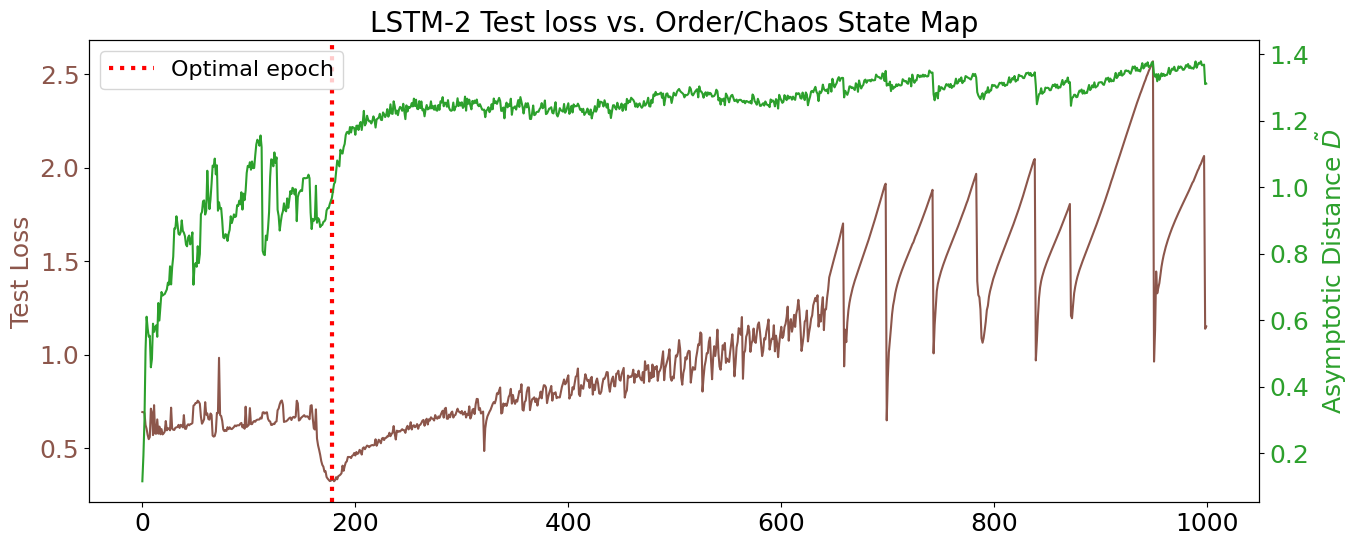

In [9]:
from scipy.stats import gmean
import matplotlib.pyplot as plt

xl=[]
with open('paper(2 and3)/paper2/vloss.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        xl.append(float(line))
len(xl)

xx = gmean(distances[:,0,:]+np.exp(-14.5-0.5),axis=1)

fig, ax1 = plt.subplots(figsize=(15.1,6))

color = 'tab:brown'
#ax1.set_xlabel('Epoch',fontsize = 16)
ax1.set_ylabel('Test Loss', color=color,fontsize = 18)
ax1.plot(np.arange(1000), xl[:1000], color=color)
# ax1.plot([182-2], xl[179], marker = 'o',label='optimal epoch',color='pink')
ax1.axvline(x = [178],ls=':', color = 'red',label = 'Optimal epoch',lw=3)
ax1.legend(loc='upper left',fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('LSTM-2 Test loss vs. Order/Chaos State Map')
ax1.title.set_size(20)

ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

color = 'tab:green'
title='Asymptotic Distance '+r'$\tilde{D}$'
ax2.set_ylabel(title, color=color,fontsize = 18)
ax2.plot(np.arange(len(xx)),np.log(xx[:len(xx)]),color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
#plt.savefig('TUPIAN/loss-epoch state change map_1.png',transparent=True)
plt.show()


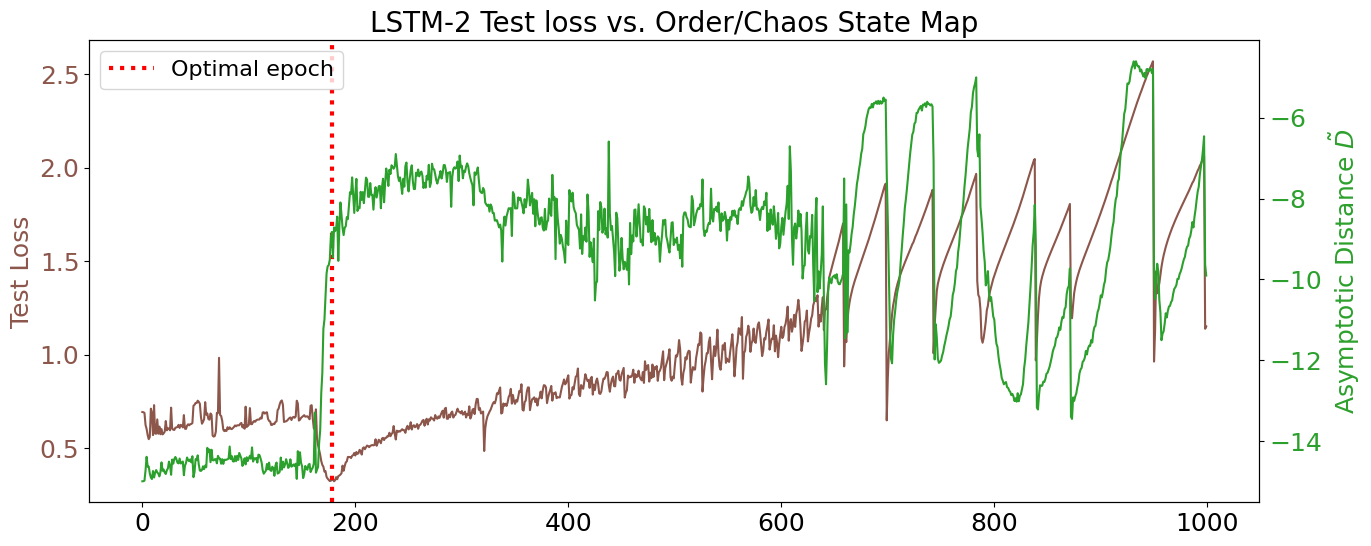

In [2]:
from scipy.stats import gmean
import matplotlib.pyplot as plt

xl=[]
with open('paper(2 and3)/paper2/vloss.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        xl.append(float(line))
len(xl)

xx = gmean(distances[:,1,:]+np.exp(-14.5-0.5),axis=1)

fig, ax1 = plt.subplots(figsize=(15.1,6))

color = 'tab:brown'
#ax1.set_xlabel('Epoch',fontsize = 16)
ax1.set_ylabel('Test Loss', color=color,fontsize = 18)
ax1.plot(np.arange(1000), xl[:1000], color=color)
# ax1.plot([182-2], xl[179], marker = 'o',label='optimal epoch',color='pink')
ax1.axvline(x = [178],ls=':', color = 'red',label = 'Optimal epoch',lw=3)
ax1.legend(loc='upper left',fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('LSTM-2 Test loss vs. Order/Chaos State Map')
ax1.title.set_size(20)

ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

color = 'tab:green'
title='Asymptotic Distance '+r'$\tilde{D}$'
ax2.set_ylabel(title, color=color,fontsize = 18)
ax2.plot(np.arange(len(xx)),np.log(xx[:len(xx)]),color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
#plt.savefig('TUPIAN/loss-epoch state change map_1.png',transparent=True)
plt.show()


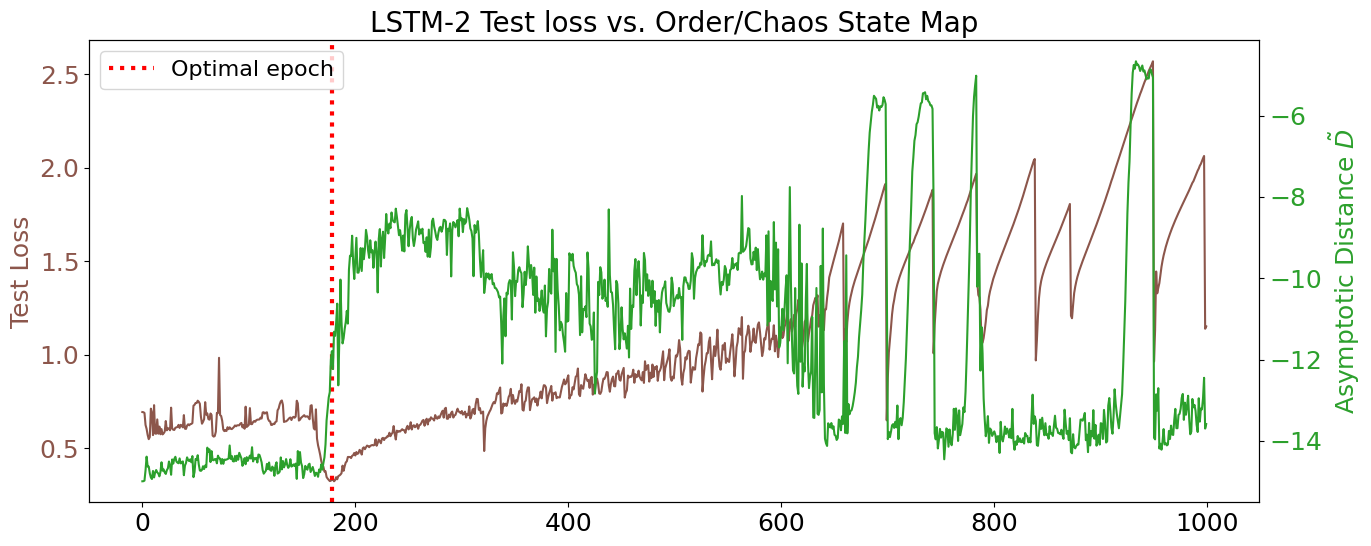

In [3]:
from scipy.stats import gmean
import matplotlib.pyplot as plt

xl=[]
with open('paper(2 and3)/paper2/vloss.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        xl.append(float(line))
len(xl)

xx = gmean(distances[:,2,:]+np.exp(-14.5-0.5),axis=1)

fig, ax1 = plt.subplots(figsize=(15.1,6))

color = 'tab:brown'
#ax1.set_xlabel('Epoch',fontsize = 16)
ax1.set_ylabel('Test Loss', color=color,fontsize = 18)
ax1.plot(np.arange(1000), xl[:1000], color=color)
# ax1.plot([182-2], xl[179], marker = 'o',label='optimal epoch',color='pink')
ax1.axvline(x = [178],ls=':', color = 'red',label = 'Optimal epoch',lw=3)
ax1.legend(loc='upper left',fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.title.set_text('LSTM-2 Test loss vs. Order/Chaos State Map')
ax1.title.set_size(20)

ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

color = 'tab:green'
title='Asymptotic Distance '+r'$\tilde{D}$'
ax2.set_ylabel(title, color=color,fontsize = 18)
ax2.plot(np.arange(len(xx)),np.log(xx[:len(xx)]),color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
#plt.savefig('TUPIAN/loss-epoch state change map_1.png',transparent=True)
plt.show()
